# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
from os import makedirs
from os.path import isfile, isdir, join, exists

data_dir   = './data'
prefix     = '.'
pkl_folder = 'pkl-files'
pkl_prefix = join(prefix, pkl_folder)

pkl_sub    = 'saved_var_checkpoint'                  #sub-folder
pkl_subpth = join(pkl_prefix, pkl_sub)       #filename will be added at runtime 

chk_folder = 'checkpoints'
chk_prefix = join(prefix, chk_folder)

chk_sub    = 'historic_losses'                       #sub-folder
chk_subpth  = join(chk_prefix, chk_sub)       #filename will be added at runtime

f_names = [chk_subpth, pkl_subpth, data_dir]

for foldername in f_names:
    if not exists(foldername):
        makedirs(foldername)

if not isdir(pkl_subpth):
    raise Exception("pkl directory doesn't exist!")
if not isdir(chk_subpth):
    raise Exception("Checkpoints directory doesn't exist!")


    
        
# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
# pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
# pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), \
'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0


/Users/gertadam/anaconda/envs/TensorFlow/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.
  


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    
    real_dim      = (image_width, image_height, image_channels)
    inputs_real   = tf.placeholder(tf.float32, (None, *real_dim), name='input_real')
    inputs_z      = tf.placeholder(tf.float32, (None, z_dim),     name='input_z')
    learning_rate = tf.placeholder(tf.float32, None,              name='learning_rate')
    
    return inputs_real, inputs_z, learning_rate

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def leaky_relu(r, alpha=0.2):
    return tf.maximum(alpha * r, r)

def array_product(array):
    result = 1
    for n in array:
        result *= int(n)
    return result

In [7]:
Dkeep_prob      = 0.6            # initialize

def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    global Dkeep_prob            
    
    kernel_init = tf.contrib.layers.xavier_initializer()
    
    # no batch norm on the 1st layer
    with tf.variable_scope('discriminator', reuse=reuse):
        kernel_size = 4
        conv1 = tf.layers.conv2d(images, 128, kernel_size, strides=2, padding='same', kernel_initializer=kernel_init)
        drop1 = tf.layers.dropout(conv1, Dkeep_prob)
        leak1 = leaky_relu(drop1, alpha=alpha)
        #print("leak1.sh",leak1.shape) #leak1.sh (?, 14, 14, 128)
        
        conv2 = tf.layers.conv2d(leak1, 256, kernel_size, strides=2, padding='same', kernel_initializer=kernel_init)
        drop2 = tf.layers.dropout(conv2, Dkeep_prob)
        bnor2 = tf.layers.batch_normalization(drop2, training=True)
        leak2 = leaky_relu(bnor2, alpha=alpha)
        #print("leak2.sh",leak2.shape) # leak2.sh (?, 7, 7, 256)
        
        conv3 = tf.layers.conv2d(leak2, 512, kernel_size, strides=2, padding='same', kernel_initializer=kernel_init)
        drop3 = tf.layers.dropout(conv3, Dkeep_prob)
        bnor3 = tf.layers.batch_normalization(drop3, training=True)
        leak3 = leaky_relu(bnor3, alpha=alpha)
        #print("leak3.sh",leak3.shape) # leak3.sh (?, 4, 4, 512)
    
        shape4 = tf.reshape(leak3, [-1, array_product(leak3.get_shape()[1:])])
        #print("shape4.sh",shape4.shape) # shape4.sh (?, 8192)
        
        logits = tf.layers.dense(shape4, 1)
        output = tf.sigmoid(logits)
    return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [51]:
Gkeep_prob      = 0.6            # initialize

def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # print("z", z.shape) # z (?, 100)
    # target (28,28, out_channel_dim)
    # inspired by http://distill.pub/2016/deconv-checkerboard/
    
    global Gkeep_prob           # another tool we can use to make the G more steady, less irratic
    kernel_init = tf.contrib.layers.xavier_initializer()
    
    with tf.variable_scope('generator', reuse=not is_train): 
        kernel_size = 2
        dense = tf.layers.dense(z, 3*3*512)
        # print("dense", dense.shape)       # dense (?, 4608)
        
        shape1 = tf.reshape(dense, [-1, 3, 3, 512])
        drop1  = tf.layers.dropout(shape1, Gkeep_prob)
        bnor1  = tf.layers.batch_normalization(drop1, training=is_train)
        leak1  = leaky_relu(bnor1)
        # print("leak1", leak1.shape)       # leak1 (?,  3, 3, 512)
        
        bili2  = tf.image.resize_images(leak1, [7, 7])    # default method=ResizeMethod.BILINEAR
        # print("bili2", bili2.shape)       # bili2 (?, 7, 7, 512)
        
        tran2  = tf.layers.conv2d_transpose(bili2, 256, kernel_size, strides=2, padding='same', \
                                            kernel_initializer=kernel_init)
        # print("tran2",tran2.shape)        # tran2 (?, 7, 7, 256)
        
        # while still trying to stabilize G - I try less Drops in the lower G: inspired by: 
        # https://medium.com/towards-data-science/gan-by-example-using-keras-on-tensorflow-backend-1a6d515a60d0
        bnor2  = tf.layers.batch_normalization(tran2, training=is_train)
        leak2  = leaky_relu(bnor2)
        
        bili3  = tf.image.resize_images(leak2, [14, 14])    # default method=ResizeMethod.BILINEAR
        # print("bili3", bili3.shape)       # bili3 (?, 14, 14, 256)
                
        tran3  = tf.layers.conv2d_transpose(bili3, 128, kernel_size, strides=2, padding='same', \
                                            kernel_initializer=kernel_init)
        # print("tran3",tran3.shape)        # tran3 (?, 14, 14, 128)
        
        bnor3  = tf.layers.batch_normalization(tran3, training=is_train)
        leak3  = leaky_relu(bnor3)
        
        bili4  = tf.image.resize_images(leak3, [28, 28])    # default method=ResizeMethod.BILINEAR
        # print("bili4", bili4.shape)     # bili4 (?, 28, 28, 128)
                        
        logits = tf.layers.conv2d_transpose(bili4, out_channel_dim, 5, strides=1, padding='same')
        # print("logits",logits.shape)    # logits (?, 28, 28, 5)
        
        # print("chan",out_channel_dim)   # chan 5
        output = tf.tanh(logits)
        
    return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # no longer two GPU's 
    # with tf.device(gpu1):
    g_model = generator(input_z, out_channel_dim)
    
    # with tf.device(gpu0):
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    d_loss_real = tf.reduce_mean(
                tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                            labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
                tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                            labels=tf.zeros_like(d_model_fake)))
    d_loss = d_loss_real + d_loss_fake
    
    g_loss = tf.reduce_mean(
                tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                            labels=tf.ones_like(d_model_fake)))
    return d_loss, g_loss

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        # with tf.device(gpu0):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        # with tf.device(gpu1):
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
        
    return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()


### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [16]:
import pickle as pkl

import time
import datetime
from datetime import timedelta 

def timestmp():
    print ("tmstmp")
    print (datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
    
def split(start_time):
    split_time = time.time()
    time_dif   = split_time - start_time
    time_str = str(timedelta(seconds = int(time_dif)))
    return time_dif, time_str
    

In [17]:
import pylab 
import numpy as np

def plot_loss(losses, steps_graph):
    fig, ax = pyplot.subplots()
    step_list = [x* steps_graph for x in range(len(losses))]
    losses = np.array(losses)
    pyplot.plot(losses.T[0], label='Discriminator', alpha=0.5)
    pyplot.plot(losses.T[1], label='Generator', alpha=0.5)
    pyplot.title("Training Losses")
    pyplot.legend()
    pyplot.show()
    

In [38]:
#from laplotter import LossAccPlotter
from collections import deque
import numpy as np

def train(epochs, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epochs: Number of epochs pr. run
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # global
    global filename
    global Load_chk
    global steps_printline
    global steps_images
    global chkfilepth
    global pckfilepth
    global num_mv_avg    
    
    # var
    steps           = 0
    laststeps       = 0
    last_elapsed    = 0
    samples, losses = [], []
    start_time      = time.time()
    mov_av_list     = deque()
    #plotter         = LossAccPlotter()
    
    image_dim = data_shape[1:]
    channels  = image_dim[-1]
    
    image_mode = "L" if channels == 1 else "RGB"
    
    input_real, input_z, lr = model_inputs(*image_dim, z_dim)
    d_loss, g_loss                     = model_loss(input_real, input_z, channels)
    d_opt, g_opt                       = model_opt(d_loss, g_loss, learning_rate, beta1)
        
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        saver           = tf.train.Saver()
        
        # implemented in train() so I can separate data from the two runs at runtime
        # so we can separate MNIST files from CELEBA-files
        chk_suffix = '.chk'
        chkfilepth = os.path.join(chk_subpth, filename+chk_suffix)
        pkl_suffix = '.pkl'
        pklfilepth = os.path.join(pkl_subpth, filename+pkl_suffix)

        # we need to add .meta - to see that the 3 chkpoint files are present
        metapklfilepth = pklfilepth+'.meta'
        
        if (Load_chk==True):
            # don't know why [isfile] wouldn't work ATM - will have to look into that..
            # ...anyway the model- & losses- restore works even if the isfile doesn't
            saver.restore(sess, chkfilepth)
            print('Model restored.')
            with open(pklfilepth, 'rb') as rl:
                losses = pkl.load(rl)
            print ('historic losses loaded')    
            
            # if isfile(metachkfilepth):
            # else:
                #raise Exception("Cannot find Checkpoint-data file [",metapklfilepth,"] doesn't exist!")
            
            # if isfile(pklfilepth):
            # else:
                # raise Exception("Losses-data file [",pklfilepth,"]doesn't exist!")
                
        timestmp    
        for epoch_i in range(epochs):
            for batch_images in get_batches(batch_size):
                steps += 1
                
                # Sample noise
                batch_z = np.random.uniform(-1, 1, size=[batch_size, z_dim])
                
                # Optimize
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, 
                                               input_z: batch_z, 
                                               lr: learning_rate})
 
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, 
                                               input_z: batch_z, 
                                               lr: learning_rate})
                
                # two xtra optimizations inspired by the chats on SLACK and the orig. GAN paper
                # this is an attempt at stabilizing the Generator and countering the Discriminator overpowering
                # the Generator 
                # so the G takes 3 little steps towards optimum - recalc - and 1 step towards opt
                # -- while D take one on the same batch
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, 
                                               input_z: batch_z, 
                                               lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, 
                                               input_z: batch_z, 
                                               lr: learning_rate})
                
                if steps % steps_printline == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    
                    elapsed_time, time_str = split(start_time)
                    elapsed_steps  = steps-laststeps
                    step_time      = elapsed_time-last_elapsed
                    st_time_str = str(timedelta(seconds = int(step_time)))
                    time_rest      = (elapsed_time/(epoch_i+1))*(epochs-epoch_i)/60
                    
                    if (len(mov_av_list)>num_mv_avg):
                        mov_av_list.popleft()
                        mov_av_list.append(time_rest)
                    else:
                        mov_av_list.append(time_rest)
                    mov_av = np.mean(mov_av_list)
                    
                    print("Epoch:{:2}/{:2}".format(epoch_i+1, epochs),
                          "Time: {:8}s.".format(time_str),
                          "st_Tm: {:8}s.".format(st_time_str),
                          "#Steps:{:4},".format(steps),
                          "DLoss:{:7.4f}".format(train_loss_d),
                          "GLoss:{:7.4f}".format(train_loss_g),
                          "guess:{:4.0f}m.".format(time_rest),
                          "average:{:4.0f}m.".format(mov_av))
                    laststeps = steps
                    last_elapsed = elapsed_time 
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))
                
                if (steps == 1) or (steps % steps_images == 0): 
                    show_generator_output(sess, 81, input_z, channels, image_mode)
                    print()
                    if (Load_chk==True):
                        plot_loss(losses, steps_graph)
                if (steps % steps_graph == 0):
                    print()
                    plot_loss(losses, steps_graph)
                    print("losses saved to: ",pklfilepth)    
                    with open(pklfilepth, 'wb') as wl:
                        pkl.dump(losses, wl)
                    
        saver.save(sess, chkfilepth)
        timestmp
        print("checkpoint saved")
        
        #does not work need to implement LossAccPlotter 
        plot_loss(losses, steps_graph)
        # trying to separate the 3 plots
        for d in range(5, 0, -1):
            print(d)
        show_generator_output(sess, 81, input_z, channels, image_mode)
        for d in range(5, 0, -1):
            print(d)
        show_generator_output(sess, 4, input_z, channels, image_mode)
        for d in range(5, 0, -1):
            print(d)
        show_generator_output(sess, 4, input_z, channels, image_mode)

    print("pickle should open: ",pklfilepth)    
    with open(pklfilepth, 'wb') as wl:
        pkl.dump(losses, wl)
    print ("finished training {} epochs".format(epochs))
    

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

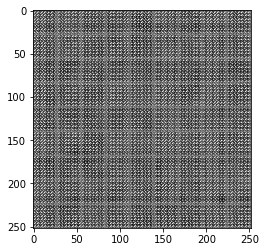


Epoch: 1/ 2 Time: 0:07:47 s. st_Tm: 0:07:47 s. #Steps:  32, DLoss: 4.1884 GLoss: 0.2463 guess:  16m. average:  16m.
Epoch: 1/ 2 Time: 0:16:02 s. st_Tm: 0:08:14 s. #Steps:  64, DLoss: 2.3140 GLoss: 6.9635 guess:  32m. average:  24m.
Epoch: 1/ 2 Time: 0:24:51 s. st_Tm: 0:08:49 s. #Steps:  96, DLoss: 0.0158 GLoss: 5.5214 guess:  50m. average:  32m.
Epoch: 1/ 2 Time: 0:34:06 s. st_Tm: 0:09:14 s. #Steps: 128, DLoss: 0.0013 GLoss: 7.8767 guess:  68m. average:  41m.


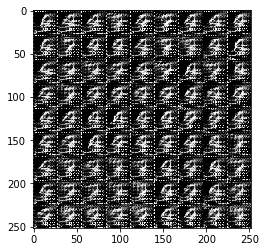


Epoch: 1/ 2 Time: 0:44:11 s. st_Tm: 0:10:05 s. #Steps: 160, DLoss: 0.0897 GLoss: 8.4933 guess:  88m. average:  51m.
Epoch: 1/ 2 Time: 0:54:02 s. st_Tm: 0:09:50 s. #Steps: 192, DLoss: 0.1353 GLoss: 6.5993 guess: 108m. average:  60m.
Epoch: 1/ 2 Time: 1:03:19 s. st_Tm: 0:09:17 s. #Steps: 224, DLoss: 0.0453 GLoss: 6.6524 guess: 127m. average:  70m.
Epoch: 1/ 2 Time: 1:12:40 s. st_Tm: 0:09:20 s. #Steps: 256, DLoss: 1.9956 GLoss: 5.2717 guess: 145m. average:  79m.


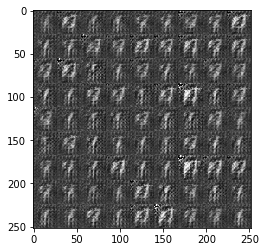

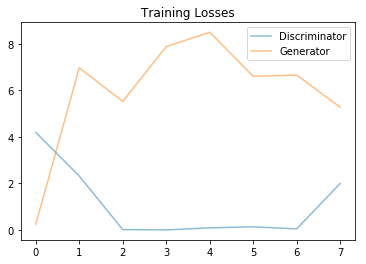

losses saved to:  ./pkl-files/saved_var_checkpoint/MNIST_run.pkl
Epoch: 1/ 2 Time: 1:22:21 s. st_Tm: 0:09:41 s. #Steps: 288, DLoss: 1.4692 GLoss: 6.6333 guess: 165m. average:  89m.
Epoch: 1/ 2 Time: 1:32:04 s. st_Tm: 0:09:42 s. #Steps: 320, DLoss: 0.8213 GLoss: 2.7240 guess: 184m. average:  98m.
Epoch: 1/ 2 Time: 1:41:50 s. st_Tm: 0:09:46 s. #Steps: 352, DLoss: 0.0649 GLoss: 5.8836 guess: 204m. average: 108m.
Epoch: 1/ 2 Time: 1:51:47 s. st_Tm: 0:09:57 s. #Steps: 384, DLoss: 0.0643 GLoss: 4.3011 guess: 224m. average: 118m.


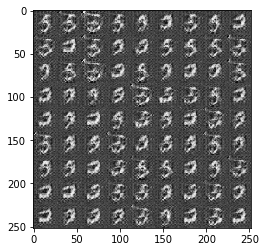


Epoch: 1/ 2 Time: 2:01:45 s. st_Tm: 0:09:58 s. #Steps: 416, DLoss: 1.7701 GLoss: 0.2778 guess: 244m. average: 127m.
Epoch: 1/ 2 Time: 2:11:13 s. st_Tm: 0:09:27 s. #Steps: 448, DLoss: 0.9930 GLoss: 4.7591 guess: 262m. average: 146m.
Epoch: 2/ 2 Time: 2:20:43 s. st_Tm: 0:09:30 s. #Steps: 480, DLoss: 0.2710 GLoss: 2.7872 guess:  70m. average: 149m.
Epoch: 2/ 2 Time: 2:30:20 s. st_Tm: 0:09:36 s. #Steps: 512, DLoss: 1.1803 GLoss: 3.7323 guess:  75m. average: 151m.


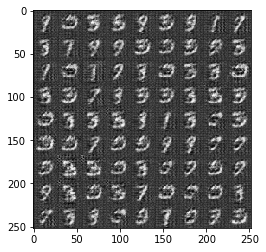

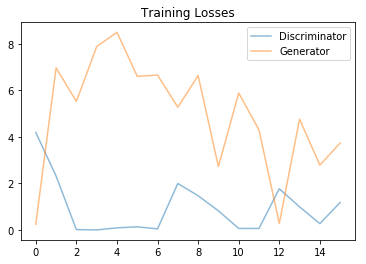

losses saved to:  ./pkl-files/saved_var_checkpoint/MNIST_run.pkl
Epoch: 2/ 2 Time: 2:40:38 s. st_Tm: 0:10:17 s. #Steps: 544, DLoss: 0.0984 GLoss: 4.9067 guess:  80m. average: 152m.
Epoch: 2/ 2 Time: 2:50:12 s. st_Tm: 0:09:33 s. #Steps: 576, DLoss: 9.7346 GLoss:15.6532 guess:  85m. average: 152m.
Epoch: 2/ 2 Time: 2:59:43 s. st_Tm: 0:09:31 s. #Steps: 608, DLoss: 1.7795 GLoss: 0.2252 guess:  90m. average: 150m.
Epoch: 2/ 2 Time: 3:09:19 s. st_Tm: 0:09:35 s. #Steps: 640, DLoss: 0.0638 GLoss: 3.9201 guess:  95m. average: 148m.


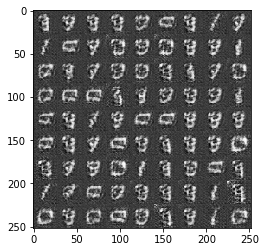


Epoch: 2/ 2 Time: 3:18:51 s. st_Tm: 0:09:32 s. #Steps: 672, DLoss: 0.0085 GLoss: 7.4950 guess:  99m. average: 144m.
Epoch: 2/ 2 Time: 3:28:12 s. st_Tm: 0:09:21 s. #Steps: 704, DLoss: 0.4772 GLoss: 2.3086 guess: 104m. average: 140m.
Epoch: 2/ 2 Time: 3:38:27 s. st_Tm: 0:10:14 s. #Steps: 736, DLoss: 0.3396 GLoss: 1.4661 guess: 109m. average: 134m.
Epoch: 2/ 2 Time: 3:49:13 s. st_Tm: 0:10:46 s. #Steps: 768, DLoss: 0.2093 GLoss: 2.9555 guess: 115m. average: 127m.


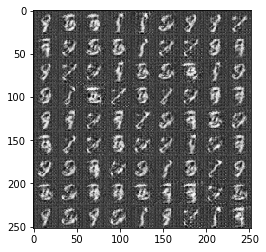

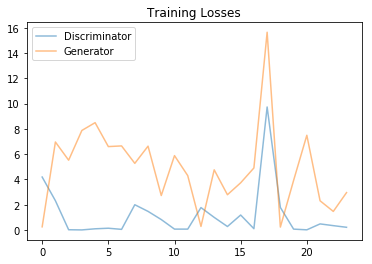

losses saved to:  ./pkl-files/saved_var_checkpoint/MNIST_run.pkl
Epoch: 2/ 2 Time: 3:58:50 s. st_Tm: 0:09:37 s. #Steps: 800, DLoss: 0.0281 GLoss: 4.7483 guess: 119m. average: 119m.
Epoch: 2/ 2 Time: 4:08:44 s. st_Tm: 0:09:53 s. #Steps: 832, DLoss: 0.0279 GLoss: 4.4463 guess: 124m. average: 110m.
Epoch: 2/ 2 Time: 4:19:04 s. st_Tm: 0:10:20 s. #Steps: 864, DLoss: 0.2354 GLoss: 2.6351 guess: 130m. average: 100m.
Epoch: 2/ 2 Time: 4:29:07 s. st_Tm: 0:10:03 s. #Steps: 896, DLoss: 0.1546 GLoss: 2.1761 guess: 135m. average: 105m.


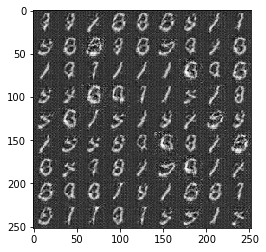


Epoch: 2/ 2 Time: 4:38:39 s. st_Tm: 0:09:32 s. #Steps: 928, DLoss: 0.0334 GLoss: 7.7324 guess: 139m. average: 110m.
checkpoint saved


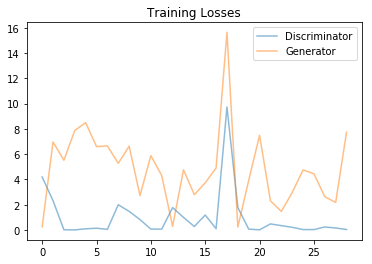

5
4
3
2
1


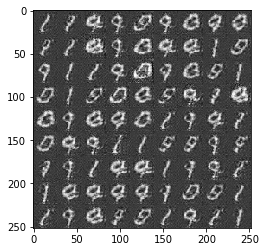

5
4
3
2
1


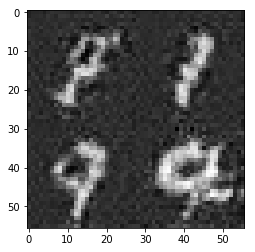

5
4
3
2
1


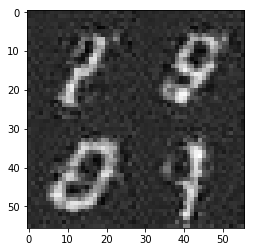

pickle should open:  ./pkl-files/saved_var_checkpoint/MNIST_run.pkl
finished training 2 epochs


In [52]:
"""
# GLOBAL VAR 
- rather than changing the params train() uses - I added these params as global 
- which I know is not strictly right, but it works for me.
"""
# std. Hyper param
batch_size    = 128
z_dim         = 100

# I created a spreadsheet to try and understand beta1, beta2, m_0, v_0 - ended up with a 40* higher lr
# I can't say anything other than: these hyperparam worked for me - hope they will for you too.
learning_rate = 0.002
beta1         = 0.5

# to seperate the two data-runs, I will have to give the files different names 
filename      = 'MNIST_run'
Load_chk      = True      # False  set this to [True], if you want to load the checkpoint and ass. losses-file

# https://medium.com/towards-data-science/gan-by-example-using-keras-on-tensorflow-backend-1a6d515a60d0
Gkeep_prob      = 0.6          # more drops, lower keep prob, but with fewer D_O layers (only in the dense)
Dkeep_prob      = 0.4          # lower keep -> to stabilize & weaken D -> to strengthen G

num_mv_avg      =  12 
steps_printline =  32 
steps_images    = 128 

steps_graph     = 256 

# delete me before handing in 
epochs          = 2

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
#epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

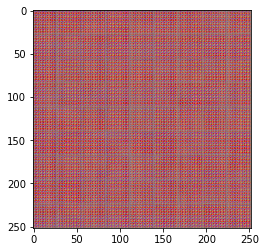


Epoch: 1/ 3 Time: 0:10:33 s. st_Tm: 0:10:33 s. #Steps:  32, DLoss: 4.0090 GLoss: 0.0512 guess:  32m. average:  32m.
Epoch: 1/ 3 Time: 0:20:12 s. st_Tm: 0:09:38 s. #Steps:  64, DLoss: 3.4299 GLoss: 0.0583 guess:  61m. average:  46m.
Epoch: 1/ 3 Time: 0:29:14 s. st_Tm: 0:09:02 s. #Steps:  96, DLoss: 0.7513 GLoss: 1.5373 guess:  88m. average:  60m.
Epoch: 1/ 3 Time: 0:38:18 s. st_Tm: 0:09:04 s. #Steps: 128, DLoss: 0.1610 GLoss: 3.6991 guess: 115m. average:  74m.


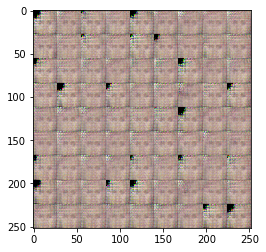


Epoch: 1/ 3 Time: 0:47:44 s. st_Tm: 0:09:26 s. #Steps: 160, DLoss: 0.1926 GLoss: 2.6769 guess: 143m. average:  88m.
Epoch: 1/ 3 Time: 0:57:39 s. st_Tm: 0:09:55 s. #Steps: 192, DLoss: 0.5271 GLoss: 2.1644 guess: 173m. average: 102m.
Epoch: 1/ 3 Time: 1:06:58 s. st_Tm: 0:09:18 s. #Steps: 224, DLoss: 1.8292 GLoss: 0.4016 guess: 201m. average: 116m.
Epoch: 1/ 3 Time: 1:15:59 s. st_Tm: 0:09:01 s. #Steps: 256, DLoss: 1.7610 GLoss: 0.4865 guess: 228m. average: 130m.


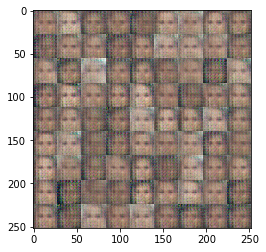

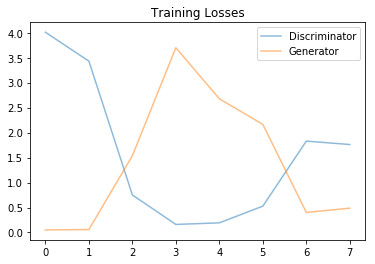

losses saved to:  ./pkl-files/saved_var_checkpoint/CelebA_run.pkl
Epoch: 1/ 3 Time: 1:25:25 s. st_Tm: 0:09:25 s. #Steps: 288, DLoss: 2.0386 GLoss: 0.2575 guess: 256m. average: 144m.
Epoch: 1/ 3 Time: 1:34:54 s. st_Tm: 0:09:28 s. #Steps: 320, DLoss: 1.7770 GLoss: 1.4900 guess: 285m. average: 158m.
Epoch: 1/ 3 Time: 1:44:11 s. st_Tm: 0:09:17 s. #Steps: 352, DLoss: 1.9563 GLoss: 0.6879 guess: 313m. average: 172m.
Epoch: 1/ 3 Time: 1:53:08 s. st_Tm: 0:08:56 s. #Steps: 384, DLoss: 1.8641 GLoss: 0.2857 guess: 339m. average: 186m.


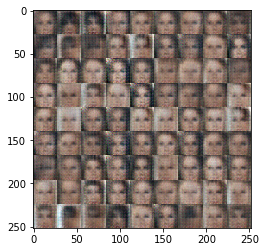


Epoch: 1/ 3 Time: 2:03:09 s. st_Tm: 0:10:01 s. #Steps: 416, DLoss: 1.7554 GLoss: 0.3188 guess: 369m. average: 200m.
Epoch: 1/ 3 Time: 2:12:55 s. st_Tm: 0:09:46 s. #Steps: 448, DLoss: 1.6882 GLoss: 0.3357 guess: 399m. average: 214m.
Epoch: 1/ 3 Time: 2:22:23 s. st_Tm: 0:09:27 s. #Steps: 480, DLoss: 1.7779 GLoss: 1.1763 guess: 427m. average: 229m.
Epoch: 1/ 3 Time: 2:31:16 s. st_Tm: 0:08:53 s. #Steps: 512, DLoss: 1.6751 GLoss: 0.5705 guess: 454m. average: 243m.


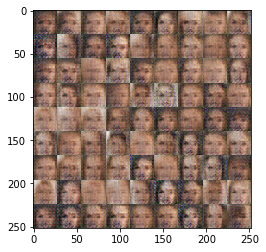

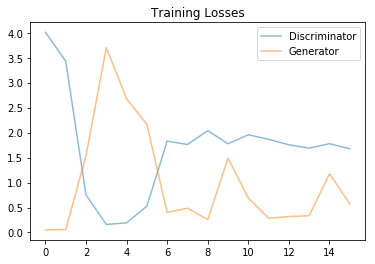

losses saved to:  ./pkl-files/saved_var_checkpoint/CelebA_run.pkl
Epoch: 1/ 3 Time: 2:40:39 s. st_Tm: 0:09:23 s. #Steps: 544, DLoss: 1.5999 GLoss: 0.6538 guess: 482m. average: 257m.
Epoch: 1/ 3 Time: 2:50:28 s. st_Tm: 0:09:49 s. #Steps: 576, DLoss: 1.9822 GLoss: 0.2384 guess: 511m. average: 271m.
Epoch: 1/ 3 Time: 3:00:56 s. st_Tm: 0:10:27 s. #Steps: 608, DLoss: 1.6122 GLoss: 0.8978 guess: 543m. average: 285m.
Epoch: 1/ 3 Time: 3:10:23 s. st_Tm: 0:09:27 s. #Steps: 640, DLoss: 1.7741 GLoss: 0.3774 guess: 571m. average: 299m.


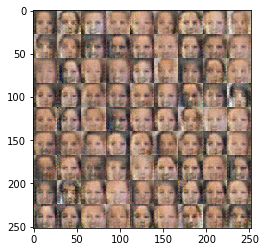


Epoch: 1/ 3 Time: 3:19:44 s. st_Tm: 0:09:20 s. #Steps: 672, DLoss: 1.5297 GLoss: 0.4851 guess: 599m. average: 314m.
Epoch: 1/ 3 Time: 3:29:38 s. st_Tm: 0:09:53 s. #Steps: 704, DLoss: 1.5640 GLoss: 0.7606 guess: 629m. average: 328m.
Epoch: 1/ 3 Time: 3:38:33 s. st_Tm: 0:08:55 s. #Steps: 736, DLoss: 1.4467 GLoss: 0.8775 guess: 656m. average: 342m.
Epoch: 1/ 3 Time: 3:46:55 s. st_Tm: 0:08:22 s. #Steps: 768, DLoss: 1.7225 GLoss: 0.3026 guess: 681m. average: 356m.


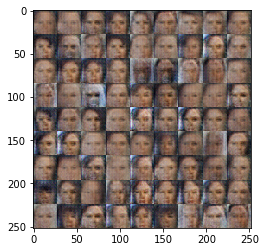

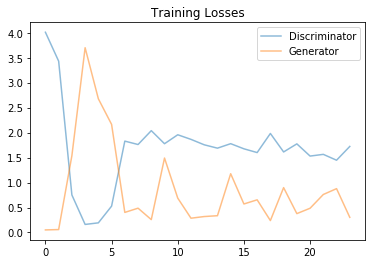

losses saved to:  ./pkl-files/saved_var_checkpoint/CelebA_run.pkl
Epoch: 1/ 3 Time: 3:55:10 s. st_Tm: 0:08:15 s. #Steps: 800, DLoss: 1.5368 GLoss: 0.3721 guess: 706m. average: 370m.
Epoch: 1/ 3 Time: 4:04:17 s. st_Tm: 0:09:06 s. #Steps: 832, DLoss: 1.7984 GLoss: 0.2532 guess: 733m. average: 398m.
Epoch: 1/ 3 Time: 4:14:52 s. st_Tm: 0:10:34 s. #Steps: 864, DLoss: 1.4140 GLoss: 0.6903 guess: 765m. average: 427m.
Epoch: 1/ 3 Time: 4:23:52 s. st_Tm: 0:09:00 s. #Steps: 896, DLoss: 1.3481 GLoss: 0.9540 guess: 792m. average: 455m.


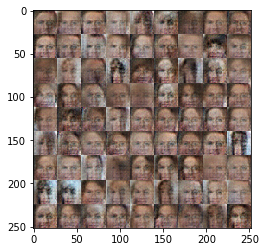


Epoch: 1/ 3 Time: 4:32:06 s. st_Tm: 0:08:14 s. #Steps: 928, DLoss: 1.5995 GLoss: 0.4821 guess: 816m. average: 483m.
Epoch: 1/ 3 Time: 4:40:24 s. st_Tm: 0:08:17 s. #Steps: 960, DLoss: 1.3841 GLoss: 0.5688 guess: 841m. average: 511m.
Epoch: 1/ 3 Time: 4:48:54 s. st_Tm: 0:08:30 s. #Steps: 992, DLoss: 1.7125 GLoss: 0.3772 guess: 867m. average: 538m.
Epoch: 1/ 3 Time: 4:57:40 s. st_Tm: 0:08:45 s. #Steps:1024, DLoss: 1.6731 GLoss: 0.2879 guess: 893m. average: 566m.


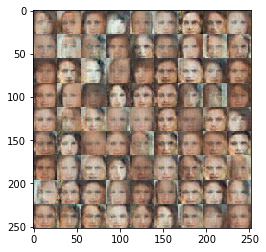

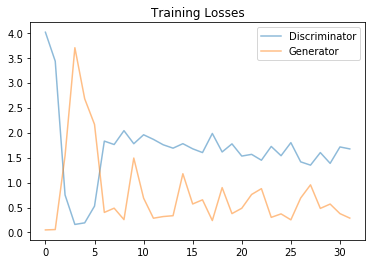

losses saved to:  ./pkl-files/saved_var_checkpoint/CelebA_run.pkl
Epoch: 1/ 3 Time: 5:06:16 s. st_Tm: 0:08:36 s. #Steps:1056, DLoss: 1.4519 GLoss: 0.7091 guess: 919m. average: 594m.
Epoch: 1/ 3 Time: 5:14:22 s. st_Tm: 0:08:05 s. #Steps:1088, DLoss: 1.1075 GLoss: 0.7645 guess: 943m. average: 621m.
Epoch: 1/ 3 Time: 5:22:43 s. st_Tm: 0:08:21 s. #Steps:1120, DLoss: 1.5528 GLoss: 0.5799 guess: 968m. average: 649m.
Epoch: 1/ 3 Time: 5:31:14 s. st_Tm: 0:08:31 s. #Steps:1152, DLoss: 1.6270 GLoss: 0.3046 guess: 994m. average: 676m.


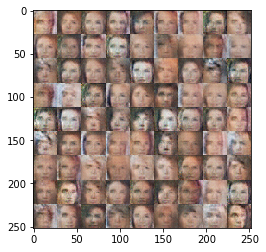


Epoch: 1/ 3 Time: 5:39:47 s. st_Tm: 0:08:32 s. #Steps:1184, DLoss: 2.0089 GLoss: 0.1997 guess:1019m. average: 703m.
Epoch: 1/ 3 Time: 5:48:07 s. st_Tm: 0:08:20 s. #Steps:1216, DLoss: 1.5585 GLoss: 0.4325 guess:1044m. average: 730m.
Epoch: 1/ 3 Time: 5:56:31 s. st_Tm: 0:08:23 s. #Steps:1248, DLoss: 1.5436 GLoss: 1.0002 guess:1070m. average: 757m.
Epoch: 1/ 3 Time: 6:04:58 s. st_Tm: 0:08:26 s. #Steps:1280, DLoss: 1.5100 GLoss: 0.6253 guess:1095m. average: 784m.


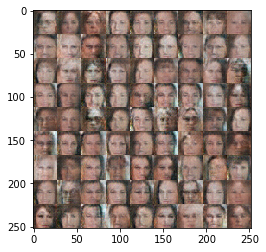

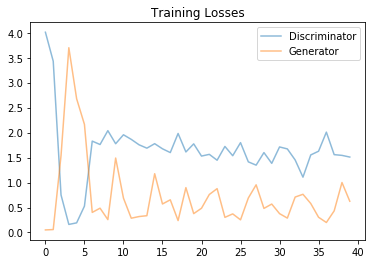

losses saved to:  ./pkl-files/saved_var_checkpoint/CelebA_run.pkl
Epoch: 1/ 3 Time: 6:13:27 s. st_Tm: 0:08:29 s. #Steps:1312, DLoss: 1.8307 GLoss: 0.2293 guess:1120m. average: 810m.
Epoch: 1/ 3 Time: 6:21:57 s. st_Tm: 0:08:29 s. #Steps:1344, DLoss: 1.6137 GLoss: 0.4006 guess:1146m. average: 837m.
Epoch: 1/ 3 Time: 6:30:10 s. st_Tm: 0:08:12 s. #Steps:1376, DLoss: 1.7621 GLoss: 0.2800 guess:1171m. average: 863m.
Epoch: 1/ 3 Time: 6:38:16 s. st_Tm: 0:08:06 s. #Steps:1408, DLoss: 1.5741 GLoss: 0.5127 guess:1195m. average: 889m.


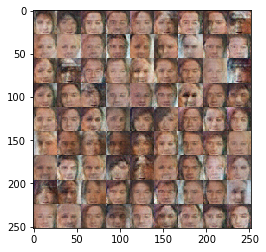


Epoch: 1/ 3 Time: 6:46:42 s. st_Tm: 0:08:25 s. #Steps:1440, DLoss: 2.0113 GLoss: 0.2012 guess:1220m. average: 915m.
Epoch: 1/ 3 Time: 6:55:14 s. st_Tm: 0:08:32 s. #Steps:1472, DLoss: 1.4177 GLoss: 0.6094 guess:1246m. average: 941m.
Epoch: 1/ 3 Time: 7:04:06 s. st_Tm: 0:08:52 s. #Steps:1504, DLoss: 1.5206 GLoss: 0.7851 guess:1272m. average: 967m.
Epoch: 1/ 3 Time: 7:12:19 s. st_Tm: 0:08:12 s. #Steps:1536, DLoss: 1.7048 GLoss: 1.1343 guess:1297m. average: 992m.


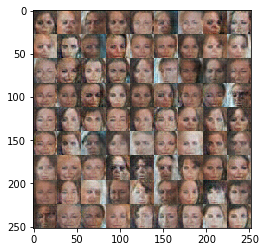

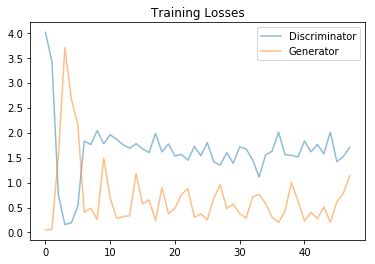

losses saved to:  ./pkl-files/saved_var_checkpoint/CelebA_run.pkl
Epoch: 1/ 3 Time: 7:20:28 s. st_Tm: 0:08:09 s. #Steps:1568, DLoss: 1.5845 GLoss: 1.0654 guess:1321m. average:1018m.
Epoch: 2/ 3 Time: 7:28:54 s. st_Tm: 0:08:26 s. #Steps:1600, DLoss: 1.5267 GLoss: 0.3620 guess: 449m. average:1008m.
Epoch: 2/ 3 Time: 7:37:22 s. st_Tm: 0:08:27 s. #Steps:1632, DLoss: 1.5432 GLoss: 0.3505 guess: 457m. average: 997m.
Epoch: 2/ 3 Time: 7:45:52 s. st_Tm: 0:08:29 s. #Steps:1664, DLoss: 1.4042 GLoss: 0.4876 guess: 466m. average: 985m.


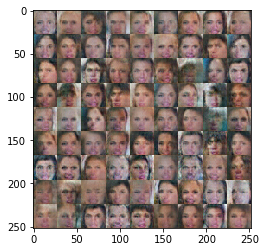


Epoch: 2/ 3 Time: 7:54:01 s. st_Tm: 0:08:08 s. #Steps:1696, DLoss: 1.4399 GLoss: 0.4298 guess: 474m. average: 972m.
Epoch: 2/ 3 Time: 8:02:32 s. st_Tm: 0:08:31 s. #Steps:1728, DLoss: 1.4061 GLoss: 0.5841 guess: 483m. average: 959m.
Epoch: 2/ 3 Time: 8:11:05 s. st_Tm: 0:08:33 s. #Steps:1760, DLoss: 1.4041 GLoss: 1.0292 guess: 491m. average: 945m.
Epoch: 2/ 3 Time: 8:19:35 s. st_Tm: 0:08:29 s. #Steps:1792, DLoss: 1.4837 GLoss: 1.3921 guess: 500m. average: 930m.


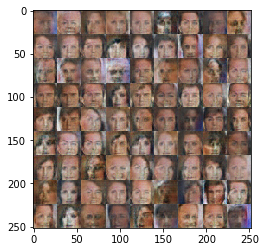

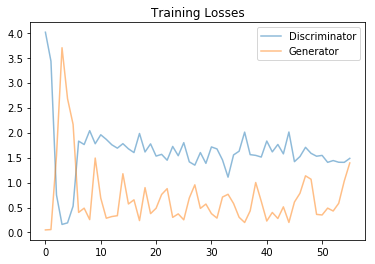

losses saved to:  ./pkl-files/saved_var_checkpoint/CelebA_run.pkl
Epoch: 2/ 3 Time: 8:28:06 s. st_Tm: 0:08:30 s. #Steps:1824, DLoss: 1.5635 GLoss: 1.1965 guess: 508m. average: 915m.
Epoch: 2/ 3 Time: 8:36:14 s. st_Tm: 0:08:07 s. #Steps:1856, DLoss: 1.6985 GLoss: 1.3335 guess: 516m. average: 899m.
Epoch: 2/ 3 Time: 8:44:26 s. st_Tm: 0:08:11 s. #Steps:1888, DLoss: 1.2142 GLoss: 1.7400 guess: 524m. average: 882m.
Epoch: 2/ 3 Time: 8:52:56 s. st_Tm: 0:08:30 s. #Steps:1920, DLoss: 1.3346 GLoss: 0.6802 guess: 533m. average: 864m.


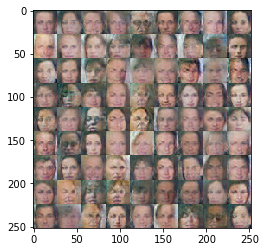


Epoch: 2/ 3 Time: 9:01:47 s. st_Tm: 0:08:50 s. #Steps:1952, DLoss: 1.1975 GLoss: 0.9299 guess: 542m. average: 846m.
Epoch: 2/ 3 Time: 9:10:17 s. st_Tm: 0:08:30 s. #Steps:1984, DLoss: 2.0127 GLoss: 0.1791 guess: 550m. average: 828m.
Epoch: 2/ 3 Time: 9:18:25 s. st_Tm: 0:08:07 s. #Steps:2016, DLoss: 1.2543 GLoss: 0.4287 guess: 558m. average: 808m.
Epoch: 2/ 3 Time: 9:26:45 s. st_Tm: 0:08:20 s. #Steps:2048, DLoss: 1.7266 GLoss: 0.2936 guess: 567m. average: 788m.


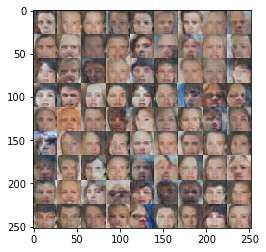

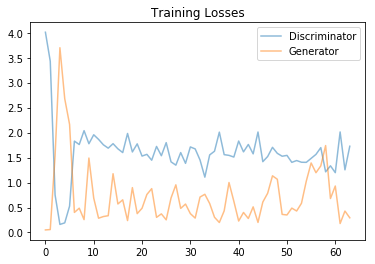

losses saved to:  ./pkl-files/saved_var_checkpoint/CelebA_run.pkl
Epoch: 2/ 3 Time: 9:35:18 s. st_Tm: 0:08:32 s. #Steps:2080, DLoss: 1.1695 GLoss: 0.9394 guess: 575m. average: 767m.
Epoch: 2/ 3 Time: 9:43:49 s. st_Tm: 0:08:31 s. #Steps:2112, DLoss: 2.2343 GLoss: 0.1427 guess: 584m. average: 746m.
Epoch: 2/ 3 Time: 9:52:13 s. st_Tm: 0:08:24 s. #Steps:2144, DLoss: 1.9269 GLoss: 0.2172 guess: 592m. average: 724m.
Epoch: 2/ 3 Time: 10:00:44s. st_Tm: 0:08:30 s. #Steps:2176, DLoss: 1.3447 GLoss: 3.2061 guess: 601m. average: 701m.


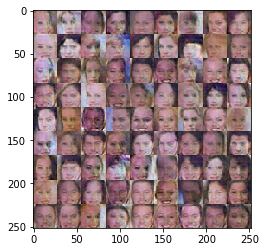


Epoch: 2/ 3 Time: 10:09:04s. st_Tm: 0:08:20 s. #Steps:2208, DLoss: 1.5142 GLoss: 0.3663 guess: 609m. average: 677m.
Epoch: 2/ 3 Time: 10:17:35s. st_Tm: 0:08:30 s. #Steps:2240, DLoss: 1.9536 GLoss: 0.1986 guess: 618m. average: 653m.
Epoch: 2/ 3 Time: 10:26:06s. st_Tm: 0:08:31 s. #Steps:2272, DLoss: 2.2445 GLoss: 0.1304 guess: 626m. average: 629m.
Epoch: 2/ 3 Time: 10:34:32s. st_Tm: 0:08:26 s. #Steps:2304, DLoss: 1.0560 GLoss: 0.9455 guess: 635m. average: 603m.


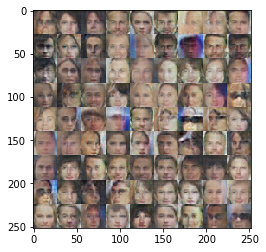

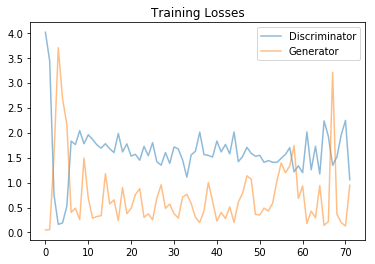

losses saved to:  ./pkl-files/saved_var_checkpoint/CelebA_run.pkl
Epoch: 2/ 3 Time: 10:42:40s. st_Tm: 0:08:08 s. #Steps:2336, DLoss: 0.9743 GLoss: 0.9111 guess: 643m. average: 577m.
Epoch: 2/ 3 Time: 10:51:02s. st_Tm: 0:08:21 s. #Steps:2368, DLoss: 1.9749 GLoss: 0.1955 guess: 651m. average: 550m.
Epoch: 2/ 3 Time: 10:59:46s. st_Tm: 0:08:44 s. #Steps:2400, DLoss: 0.9945 GLoss: 1.0625 guess: 660m. average: 558m.
Epoch: 2/ 3 Time: 11:08:29s. st_Tm: 0:08:43 s. #Steps:2432, DLoss: 0.9430 GLoss: 1.3555 guess: 668m. average: 567m.


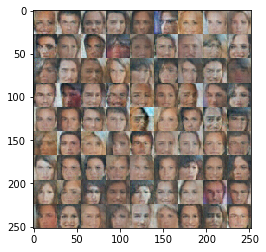


Epoch: 2/ 3 Time: 11:16:42s. st_Tm: 0:08:13 s. #Steps:2464, DLoss: 1.5073 GLoss: 0.3858 guess: 677m. average: 575m.
Epoch: 2/ 3 Time: 11:24:49s. st_Tm: 0:08:06 s. #Steps:2496, DLoss: 1.2009 GLoss: 0.4791 guess: 685m. average: 584m.
Epoch: 2/ 3 Time: 11:33:19s. st_Tm: 0:08:29 s. #Steps:2528, DLoss: 1.4672 GLoss: 0.3586 guess: 693m. average: 592m.
Epoch: 2/ 3 Time: 11:41:50s. st_Tm: 0:08:31 s. #Steps:2560, DLoss: 2.2880 GLoss: 0.1761 guess: 702m. average: 601m.


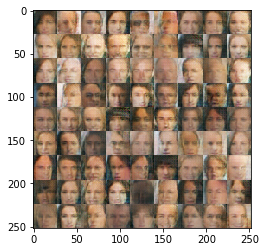

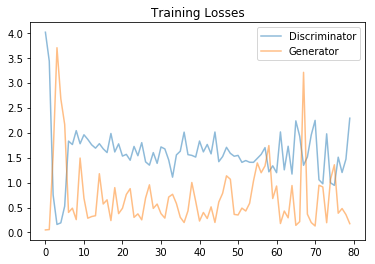

losses saved to:  ./pkl-files/saved_var_checkpoint/CelebA_run.pkl
Epoch: 2/ 3 Time: 11:50:29s. st_Tm: 0:08:38 s. #Steps:2592, DLoss: 1.0038 GLoss: 1.2254 guess: 710m. average: 609m.
Epoch: 2/ 3 Time: 11:58:51s. st_Tm: 0:08:22 s. #Steps:2624, DLoss: 1.7287 GLoss: 0.2626 guess: 719m. average: 618m.
Epoch: 2/ 3 Time: 12:07:17s. st_Tm: 0:08:25 s. #Steps:2656, DLoss: 1.0337 GLoss: 0.6177 guess: 727m. average: 626m.
Epoch: 2/ 3 Time: 12:15:46s. st_Tm: 0:08:28 s. #Steps:2688, DLoss: 3.3283 GLoss: 2.3890 guess: 736m. average: 634m.


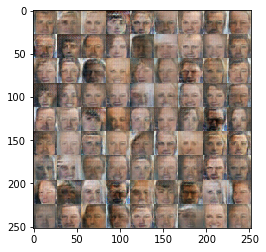


Epoch: 2/ 3 Time: 12:24:18s. st_Tm: 0:08:32 s. #Steps:2720, DLoss: 0.9930 GLoss: 0.9771 guess: 744m. average: 643m.
Epoch: 2/ 3 Time: 12:32:46s. st_Tm: 0:08:27 s. #Steps:2752, DLoss: 1.3067 GLoss: 0.4298 guess: 753m. average: 651m.
Epoch: 2/ 3 Time: 12:40:56s. st_Tm: 0:08:10 s. #Steps:2784, DLoss: 0.7265 GLoss: 1.8098 guess: 761m. average: 660m.
Epoch: 2/ 3 Time: 12:49:11s. st_Tm: 0:08:15 s. #Steps:2816, DLoss: 1.1288 GLoss: 0.8328 guess: 769m. average: 668m.


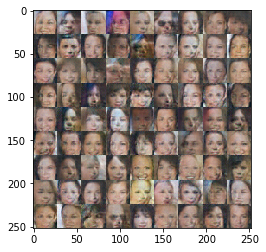

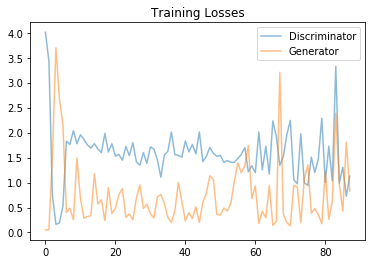

losses saved to:  ./pkl-files/saved_var_checkpoint/CelebA_run.pkl
Epoch: 2/ 3 Time: 12:57:57s. st_Tm: 0:08:45 s. #Steps:2848, DLoss: 0.9574 GLoss: 1.3118 guess: 778m. average: 677m.
Epoch: 2/ 3 Time: 13:06:40s. st_Tm: 0:08:43 s. #Steps:2880, DLoss: 1.7523 GLoss: 0.2589 guess: 787m. average: 685m.
Epoch: 2/ 3 Time: 13:14:53s. st_Tm: 0:08:12 s. #Steps:2912, DLoss: 1.1939 GLoss: 0.5800 guess: 795m. average: 694m.
Epoch: 2/ 3 Time: 13:22:53s. st_Tm: 0:08:00 s. #Steps:2944, DLoss: 1.8014 GLoss: 0.2482 guess: 803m. average: 702m.


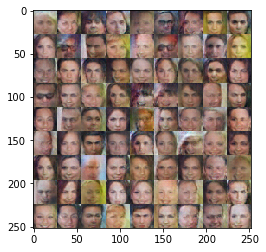


Epoch: 2/ 3 Time: 13:31:09s. st_Tm: 0:08:15 s. #Steps:2976, DLoss: 0.6408 GLoss: 1.7134 guess: 811m. average: 710m.
Epoch: 2/ 3 Time: 13:39:30s. st_Tm: 0:08:21 s. #Steps:3008, DLoss: 1.4645 GLoss: 0.3718 guess: 820m. average: 719m.
Epoch: 2/ 3 Time: 13:47:56s. st_Tm: 0:08:26 s. #Steps:3040, DLoss: 1.5368 GLoss: 2.7892 guess: 828m. average: 727m.
Epoch: 2/ 3 Time: 13:57:18s. st_Tm: 0:09:21 s. #Steps:3072, DLoss: 1.0403 GLoss: 0.7298 guess: 837m. average: 736m.


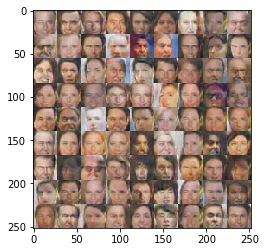

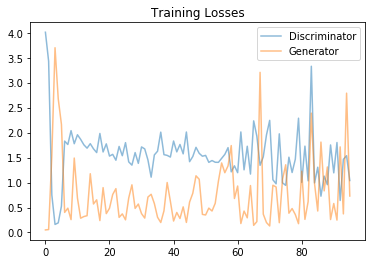

losses saved to:  ./pkl-files/saved_var_checkpoint/CelebA_run.pkl
Epoch: 2/ 3 Time: 14:06:05s. st_Tm: 0:08:46 s. #Steps:3104, DLoss: 0.9358 GLoss: 1.1268 guess: 846m. average: 744m.
Epoch: 2/ 3 Time: 14:15:57s. st_Tm: 0:09:51 s. #Steps:3136, DLoss: 1.1793 GLoss: 0.6212 guess: 856m. average: 753m.
Epoch: 3/ 3 Time: 14:29:24s. st_Tm: 0:13:27 s. #Steps:3168, DLoss: 2.1893 GLoss: 0.1669 guess: 290m. average: 738m.
Epoch: 3/ 3 Time: 14:39:20s. st_Tm: 0:09:55 s. #Steps:3200, DLoss: 1.5041 GLoss: 0.3349 guess: 293m. average: 724m.


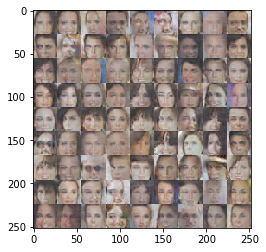


Epoch: 3/ 3 Time: 14:49:33s. st_Tm: 0:10:13 s. #Steps:3232, DLoss: 2.1015 GLoss: 0.1731 guess: 297m. average: 709m.
Epoch: 3/ 3 Time: 15:00:35s. st_Tm: 0:11:01 s. #Steps:3264, DLoss: 1.5898 GLoss: 0.3896 guess: 300m. average: 694m.
Epoch: 3/ 3 Time: 15:12:25s. st_Tm: 0:11:50 s. #Steps:3296, DLoss: 1.9730 GLoss: 1.6860 guess: 304m. average: 678m.
Epoch: 3/ 3 Time: 15:23:26s. st_Tm: 0:11:01 s. #Steps:3328, DLoss: 1.5860 GLoss: 0.3033 guess: 308m. average: 663m.


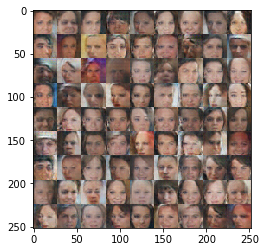

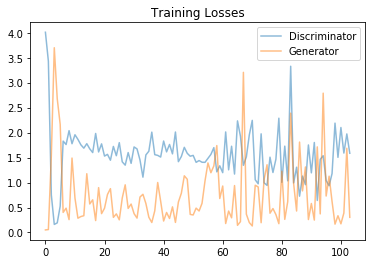

losses saved to:  ./pkl-files/saved_var_checkpoint/CelebA_run.pkl
Epoch: 3/ 3 Time: 15:33:47s. st_Tm: 0:10:20 s. #Steps:3360, DLoss: 1.1938 GLoss: 0.5618 guess: 311m. average: 647m.
Epoch: 3/ 3 Time: 15:45:07s. st_Tm: 0:11:20 s. #Steps:3392, DLoss: 0.5536 GLoss: 2.4301 guess: 315m. average: 631m.
Epoch: 3/ 3 Time: 15:56:22s. st_Tm: 0:11:14 s. #Steps:3424, DLoss: 0.7468 GLoss: 3.9315 guess: 319m. average: 615m.
Epoch: 3/ 3 Time: 16:07:39s. st_Tm: 0:11:17 s. #Steps:3456, DLoss: 1.8463 GLoss: 0.2359 guess: 323m. average: 599m.


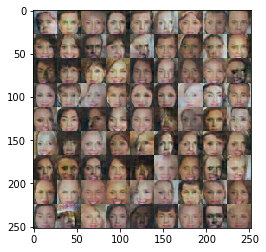


Epoch: 3/ 3 Time: 16:18:01s. st_Tm: 0:10:21 s. #Steps:3488, DLoss: 1.8724 GLoss: 0.2107 guess: 326m. average: 583m.
Epoch: 3/ 3 Time: 16:28:24s. st_Tm: 0:10:22 s. #Steps:3520, DLoss: 1.7438 GLoss: 0.2684 guess: 329m. average: 566m.
Epoch: 3/ 3 Time: 16:39:45s. st_Tm: 0:11:21 s. #Steps:3552, DLoss: 1.2205 GLoss: 0.5469 guess: 333m. average: 550m.
Epoch: 3/ 3 Time: 16:49:33s. st_Tm: 0:09:47 s. #Steps:3584, DLoss: 1.5881 GLoss: 0.3766 guess: 337m. average: 533m.


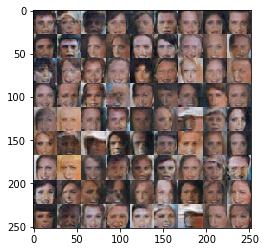

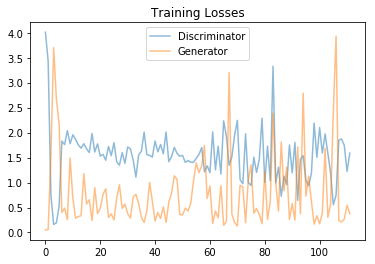

losses saved to:  ./pkl-files/saved_var_checkpoint/CelebA_run.pkl
Epoch: 3/ 3 Time: 16:58:41s. st_Tm: 0:09:08 s. #Steps:3616, DLoss: 1.3209 GLoss: 0.4439 guess: 340m. average: 515m.
Epoch: 3/ 3 Time: 17:08:30s. st_Tm: 0:09:49 s. #Steps:3648, DLoss: 0.6684 GLoss: 1.4875 guess: 343m. average: 498m.
Epoch: 3/ 3 Time: 17:18:45s. st_Tm: 0:10:14 s. #Steps:3680, DLoss: 0.7048 GLoss: 1.1593 guess: 346m. average: 480m.
Epoch: 3/ 3 Time: 17:28:14s. st_Tm: 0:09:28 s. #Steps:3712, DLoss: 1.3166 GLoss: 0.4592 guess: 349m. average: 463m.


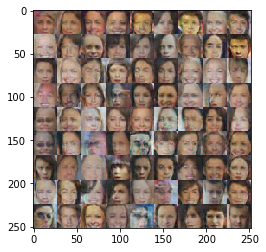


Epoch: 3/ 3 Time: 17:37:12s. st_Tm: 0:08:58 s. #Steps:3744, DLoss: 0.5164 GLoss: 2.4522 guess: 352m. average: 445m.
Epoch: 3/ 3 Time: 17:46:37s. st_Tm: 0:09:24 s. #Steps:3776, DLoss: 0.7526 GLoss: 1.4585 guess: 356m. average: 426m.
Epoch: 3/ 3 Time: 17:56:17s. st_Tm: 0:09:40 s. #Steps:3808, DLoss: 1.0265 GLoss: 0.7038 guess: 359m. average: 408m.
Epoch: 3/ 3 Time: 18:06:36s. st_Tm: 0:10:18 s. #Steps:3840, DLoss: 1.3891 GLoss: 0.4207 guess: 362m. average: 389m.


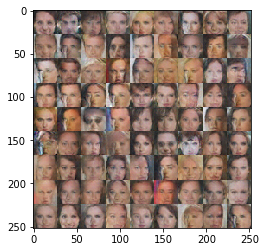

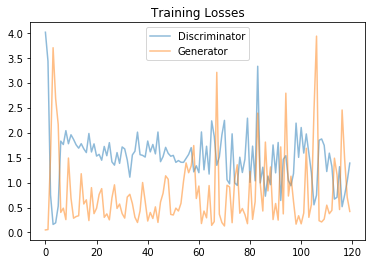

losses saved to:  ./pkl-files/saved_var_checkpoint/CelebA_run.pkl
Epoch: 3/ 3 Time: 18:15:39s. st_Tm: 0:09:03 s. #Steps:3872, DLoss: 0.9248 GLoss: 1.6344 guess: 365m. average: 370m.
Epoch: 3/ 3 Time: 18:24:35s. st_Tm: 0:08:56 s. #Steps:3904, DLoss: 1.9265 GLoss: 0.2209 guess: 368m. average: 351m.
Epoch: 3/ 3 Time: 18:34:05s. st_Tm: 0:09:30 s. #Steps:3936, DLoss: 0.4341 GLoss: 2.7728 guess: 371m. average: 332m.
Epoch: 3/ 3 Time: 18:43:37s. st_Tm: 0:09:32 s. #Steps:3968, DLoss: 1.6675 GLoss: 0.2688 guess: 375m. average: 335m.


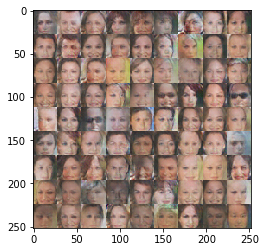


Epoch: 3/ 3 Time: 18:53:16s. st_Tm: 0:09:38 s. #Steps:4000, DLoss: 1.1270 GLoss: 0.5617 guess: 378m. average: 339m.
Epoch: 3/ 3 Time: 19:02:16s. st_Tm: 0:08:59 s. #Steps:4032, DLoss: 0.8284 GLoss: 1.0694 guess: 381m. average: 342m.
Epoch: 3/ 3 Time: 19:11:25s. st_Tm: 0:09:09 s. #Steps:4064, DLoss: 0.5631 GLoss: 3.3587 guess: 384m. average: 345m.
Epoch: 3/ 3 Time: 19:20:57s. st_Tm: 0:09:31 s. #Steps:4096, DLoss: 1.1809 GLoss: 0.6537 guess: 387m. average: 349m.


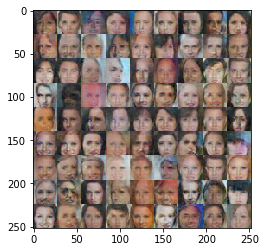

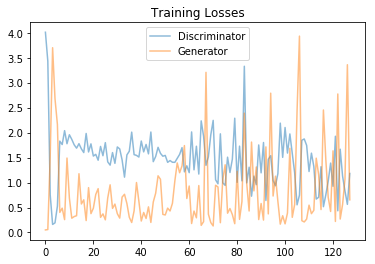

losses saved to:  ./pkl-files/saved_var_checkpoint/CelebA_run.pkl
Epoch: 3/ 3 Time: 19:30:30s. st_Tm: 0:09:33 s. #Steps:4128, DLoss: 0.5877 GLoss: 2.8941 guess: 390m. average: 352m.
Epoch: 3/ 3 Time: 19:39:52s. st_Tm: 0:09:21 s. #Steps:4160, DLoss: 0.5853 GLoss: 1.7536 guess: 393m. average: 355m.
Epoch: 3/ 3 Time: 19:48:45s. st_Tm: 0:08:52 s. #Steps:4192, DLoss: 1.5361 GLoss: 0.3562 guess: 396m. average: 358m.
Epoch: 3/ 3 Time: 19:57:12s. st_Tm: 0:08:27 s. #Steps:4224, DLoss: 0.4896 GLoss: 2.5995 guess: 399m. average: 362m.


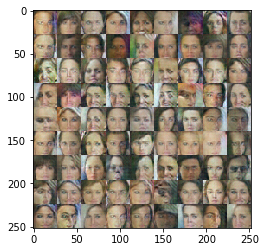


Epoch: 3/ 3 Time: 20:05:48s. st_Tm: 0:08:36 s. #Steps:4256, DLoss: 1.0858 GLoss: 0.5466 guess: 402m. average: 365m.
Epoch: 3/ 3 Time: 20:14:21s. st_Tm: 0:08:32 s. #Steps:4288, DLoss: 1.4058 GLoss: 0.4169 guess: 405m. average: 368m.
Epoch: 3/ 3 Time: 20:22:46s. st_Tm: 0:08:24 s. #Steps:4320, DLoss: 0.8680 GLoss: 0.8385 guess: 408m. average: 371m.
Epoch: 3/ 3 Time: 20:30:53s. st_Tm: 0:08:07 s. #Steps:4352, DLoss: 0.4025 GLoss: 2.1389 guess: 410m. average: 374m.


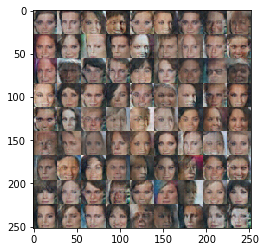

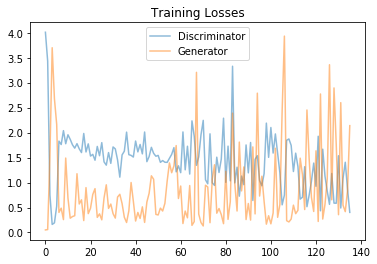

losses saved to:  ./pkl-files/saved_var_checkpoint/CelebA_run.pkl
Epoch: 3/ 3 Time: 20:39:15s. st_Tm: 0:08:22 s. #Steps:4384, DLoss: 0.8951 GLoss: 0.8485 guess: 413m. average: 377m.
Epoch: 3/ 3 Time: 20:47:47s. st_Tm: 0:08:31 s. #Steps:4416, DLoss: 0.2929 GLoss: 1.9016 guess: 416m. average: 380m.
Epoch: 3/ 3 Time: 20:56:19s. st_Tm: 0:08:31 s. #Steps:4448, DLoss: 2.4491 GLoss: 4.5519 guess: 419m. average: 383m.
Epoch: 3/ 3 Time: 21:05:31s. st_Tm: 0:09:11 s. #Steps:4480, DLoss: 0.8951 GLoss: 0.8497 guess: 422m. average: 386m.


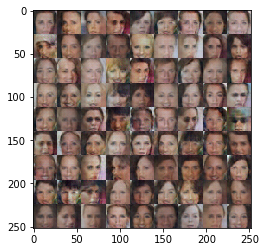


Epoch: 3/ 3 Time: 21:14:44s. st_Tm: 0:09:13 s. #Steps:4512, DLoss: 1.2279 GLoss: 0.5034 guess: 425m. average: 389m.
Epoch: 3/ 3 Time: 21:24:15s. st_Tm: 0:09:31 s. #Steps:4544, DLoss: 3.2849 GLoss: 0.0563 guess: 428m. average: 392m.
Epoch: 3/ 3 Time: 21:33:15s. st_Tm: 0:08:59 s. #Steps:4576, DLoss: 1.0842 GLoss: 0.6138 guess: 431m. average: 395m.
Epoch: 3/ 3 Time: 21:41:47s. st_Tm: 0:08:31 s. #Steps:4608, DLoss: 1.4829 GLoss: 2.6602 guess: 434m. average: 398m.


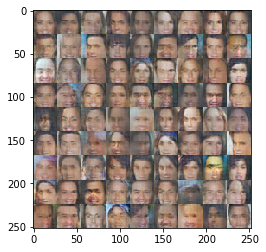

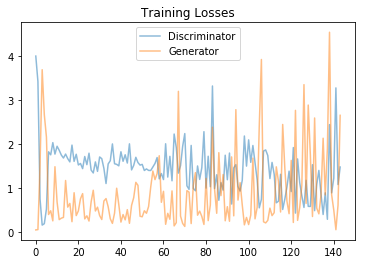

losses saved to:  ./pkl-files/saved_var_checkpoint/CelebA_run.pkl
Epoch: 3/ 3 Time: 21:50:05s. st_Tm: 0:08:17 s. #Steps:4640, DLoss: 0.5715 GLoss: 1.7926 guess: 437m. average: 401m.
Epoch: 3/ 3 Time: 21:58:15s. st_Tm: 0:08:09 s. #Steps:4672, DLoss: 1.4848 GLoss: 0.3874 guess: 439m. average: 404m.
Epoch: 3/ 3 Time: 22:06:42s. st_Tm: 0:08:27 s. #Steps:4704, DLoss: 0.8298 GLoss: 0.9857 guess: 442m. average: 407m.
Epoch: 3/ 3 Time: 22:15:12s. st_Tm: 0:08:29 s. #Steps:4736, DLoss: 0.4137 GLoss: 3.2955 guess: 445m. average: 410m.


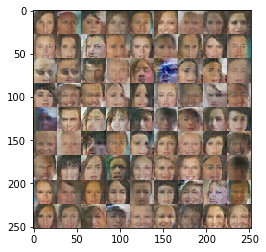


checkpoint saved


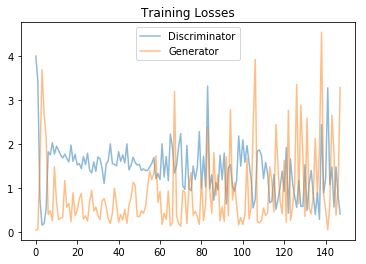

5
4
3
2
1


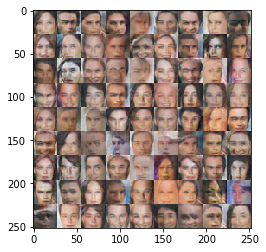

5
4
3
2
1


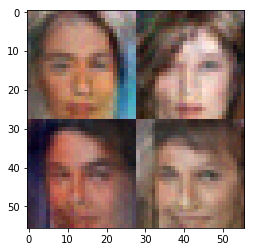

5
4
3
2
1


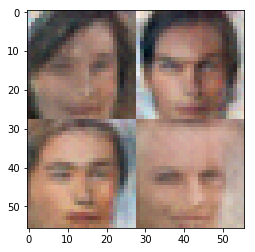

pickle should open:  ./pkl-files/saved_var_checkpoint/CelebA_run.pkl
finished training 3 epochs


In [53]:
"""
# GLOBAL VAR 
- rather than changing the params train() uses - I added these params as global 
- which I know is not strictly right, but it works for me.
"""

# std. Hyper param
batch_size     = 256
z_dim          = 100

# I created a spreadsheet to try and understand beta1, beta2, m_0, v_0 - ended up with a 40* higher lr
# I can't say anything other than: these worked for me - hope they will for you too.
learning_rate  = 0.002
beta1          = 0.5

# to seperate the two data-runs, I will have to give the files different names 
filename       = 'CelebA_run'
Load_chk       = True  # False  # set this to [True], if you want to load the checkpoint and ass. losses-file

# https://medium.com/towards-data-science/gan-by-example-using-keras-on-tensorflow-backend-1a6d515a60d0
Gkeep_prob      = 0.6  # more drops -> lower keep prob but with fewer D_O layers (only in the dense)
Dkeep_prob      = 0.4

num_mv_avg      =  24                            
steps_printline =  32
steps_images    = 128 

steps_graph     = 256

# delete me before handing in - on laptop 1 epoch -> 1 hour)
epochs          =   3

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
#epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.